In [1]:
import pandas as pd, numpy as np
from datetime import datetime
# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

https://pypi.org/project/yfinance/

# Technical Indicators

# All Chinese Stocks

## 上证指数

In [22]:
# 网易爬数据

def get_page(url):  #获取页面数据
    req=urllib.request.Request(url,headers={
        'Connection': 'Keep-Alive',
        'Accept': 'text/html, application/xhtml+xml, */*',
        'Accept-Language':'zh-CN,zh;q=0.8',
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko'
    })
    opener=urllib.request.urlopen(req)
    page=opener.read()
    return page

def get_index_history_byNetease(index_temp):
    """
    :param index_temp: for example, 'sh000001' 上证指数
    :return:
    """
    index_type=index_temp[0:2]
    index_id=index_temp[2:]
    if index_type=='sh':
        index_id='0'+index_id
    if index_type=="sz":
        index_id='1'+index_id
    url='http://quotes.money.163.com/service/chddata.html?code=%s&start=19900101&end=%s&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER'%(index_id,time.strftime("%Y%m%d"))

    page=get_page(url).decode('gb2312') #该段获取原始数据
    page=page.split('\r\n')
    col_info=page[0].split(',')   #各列的含义
    index_data=page[1:]     #真正的数据

    #为了与现有的数据库对应，这里我还修改了列名，大家不改也没关系
    col_info[col_info.index('日期')]='交易日期'   #该段更改列名称
    col_info[col_info.index('股票代码')]='指数代码'
    col_info[col_info.index('名称')]='指数名称'
    col_info[col_info.index('成交金额')]='成交额'

    index_data=[x.replace("'",'') for x in index_data]  #去掉指数编号前的“'”
    index_data=[x.split(',') for x in index_data]

    index_data=index_data[0:index_data.__len__()-1]   #最后一行为空，需要去掉
    pos1=col_info.index('涨跌幅')
    pos2=col_info.index('涨跌额')
    posclose=col_info.index('收盘价')
    index_data[index_data.__len__()-1][pos1]=0      #最下面行涨跌额和涨跌幅为None改为0
    index_data[index_data.__len__()-1][pos2]=0
    for i in range(0,index_data.__len__()-1):       #这两列中有些值莫名其妙为None 现在补全
        if index_data[i][pos2]=='None':
            index_data[i][pos2]=float(index_data[i][posclose])-float(index_data[i+1][posclose])
        if index_data[i][pos1]=='None':
            index_data[i][pos1]=(float(index_data[i][posclose])-float(index_data[i+1][posclose]))/float(index_data[i+1][posclose])

    # print(col_info)
    return [index_data,col_info]
# --------------------- 
# 版权声明：本文为CSDN博主「multiangle」的原创文章，遵循CC 4.0 by-sa版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/u014595019/article/details/48445223

sh = get_index_history_byNetease("sh000001") 
df_ne = pd.DataFrame()
df_ne['columns_to_split'] = pd.DataFrame(sh).T[0]
col_list = list(pd.DataFrame(sh).T[1])[:12]
df_ne['columns_to_split'] = df_ne['columns_to_split'].apply(lambda x: str(x))
df_ne['columns_to_split'] = df_ne['columns_to_split'].apply(lambda x: x.replace("[", ""))
df_ne['columns_to_split'] = df_ne['columns_to_split'].apply(lambda x: x.replace("]", ""))

df_ne = df_ne['columns_to_split'].str.split(",", 12, expand = True)
df_ne.columns = col_list
df_ne.sort_values("交易日期", inplace = True)
df_ne.reset_index(inplace = True)
del df_ne['index']
df_ne.tail()

,交易日期,指数代码,指数名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,成交量,成交额
7066,'2019-11-14','000001','上证指数','2909.8697','2917.374','2899.6186','2907.7358','2905.2409','4.6288','0.1593','129145448','1.51576183392e+11'
7067,'2019-11-15','000001','上证指数','2891.3431','2917.8293','2891.2043','2911.35','2909.8697','-18.5266','-0.6367','135519463','1.52576392736e+11'
7068,'2019-11-18','000001','上证指数','2909.2002','2911.3784','2884.0883','2889.5495','2891.3431','17.8571','0.6176','124433177','1.44677413724e+11'
7069,'2019-11-19','000001','上证指数','2933.9908','2933.9908','2902.855','2904.2783','2909.2002','24.7906','0.8521','135417604','1.55770741258e+11'
7070,'2019-11-20','000001','上证指数','2911.0534','2930.4929','2907.4229','2928.1068','2933.9908','-22.9374','-0.7818','137357530','1.58543195636e+11'


In [24]:
df_ne = df_ne[['交易日期', '开盘价', '最高价', '最低价', '收盘价', '成交量']]
df_ne = df_ne.iloc[1:, :]
df_ne['交易日期'] = df_ne['交易日期'].apply(lambda x: x[1:-1])
df_ne['收盘价'] = df_ne['收盘价'].apply(lambda x: x[2:-1])
df_ne['收盘价'] = df_ne['收盘价'] = df_ne['收盘价'].apply(lambda x: float(x))
df_ne['最高价'] = df_ne['最高价'].apply(lambda x: x[2:-1])
df_ne['最高价'] = df_ne['最高价'] = df_ne['最高价'].apply(lambda x: float(x))
df_ne['最低价'] = df_ne['最低价'].apply(lambda x: x[2:-1])
df_ne['最低价'] = df_ne['最低价'] = df_ne['最低价'].apply(lambda x: float(x))
df_ne['开盘价'] = df_ne['开盘价'].apply(lambda x: x[2:-1])
df_ne['开盘价'] = df_ne['开盘价'] = df_ne['开盘价'].apply(lambda x: float(x))
# df_ne['前收盘'] = df_ne['前收盘'].apply(lambda x: x[2:-1])
# df_ne['前收盘'] = df_ne['前收盘'] = df_ne['前收盘'].apply(lambda x: float(x))
# df_ne['涨跌额'] = df_ne['涨跌额'].apply(lambda x: x[2:-1])
# df_ne['涨跌额'] = df_ne['涨跌额'] = df_ne['涨跌额'].apply(lambda x: float(x))
# df_ne['涨跌幅'] = df_ne['涨跌幅'].apply(lambda x: x[2:-1])
# df_ne['涨跌幅'] = df_ne['涨跌幅'] = df_ne['涨跌幅'].apply(lambda x: float(x))
df_ne['成交量'] = df_ne['成交量'].apply(lambda x: x[2:-1])
df_ne['成交量'] = df_ne['成交量'] = df_ne['成交量'].apply(lambda x: float(x))
# df_ne['成交额'] = df_ne['成交额'].apply(lambda x: x[2:-1])
# df_ne['成交额'] = df_ne['成交额'] = df_ne['成交额'].apply(lambda x: float(x))
df_ne.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

In [25]:
df_ne['']

,date,open,high,low,close,volume
1,1990-12-20,104.3000,104.3900,99.9800,104.3900,197.0
2,1990-12-21,109.0700,109.1300,103.7300,109.1300,28.0
3,1990-12-24,113.5700,114.5500,109.1300,114.5500,32.0
4,1990-12-25,120.0900,120.2500,114.5500,120.2500,15.0
5,1990-12-26,125.2700,125.2700,120.2500,125.2700,100.0
6,1990-12-27,125.2700,125.2800,125.2700,125.2800,66.0
7,1990-12-28,126.3900,126.4500,125.2800,126.4500,108.0
8,1990-12-31,126.5600,127.6100,126.4800,127.6100,78.0
9,1991-01-02,127.6100,128.8400,127.6100,128.8400,91.0
10,1991-01-03,128.8400,130.1400,128.8400,130.1400,141.0


In [56]:
# Gary's project:

def MA(df, n): # n = 5
    """
    Moving Average
    rationale CHECKED, code CHECKED. updated

    params:
        df: pd dataframe 
        n: number of days = 5
    """
    MA = df['close'].rolling(window=n, center=False).mean().rename('MA_' + str(n))
    df['MA{}'.format(n)] = MA
    return df

In [72]:
df_MA5 = MA(df_ne, 5)
df_MA5_ = df_MA5[['date','open','close','MA5']]
df_MA5_.index =  df_MA5_['date']
df_MA5_ = df_MA5_[df_MA5_['date']>"2009-01-01"]
del df_MA5_['date']

In [73]:
df_MA5_['pre_close'] = df_MA5_['close'].shift(1)
df_MA5_['gap_pct'] = (df_MA5_['open'] - df_MA5_['pre_close'])/df_MA5_['pre_close']
df_MA5_['pre_MA5'] = df_MA5_['MA5'].shift(1)

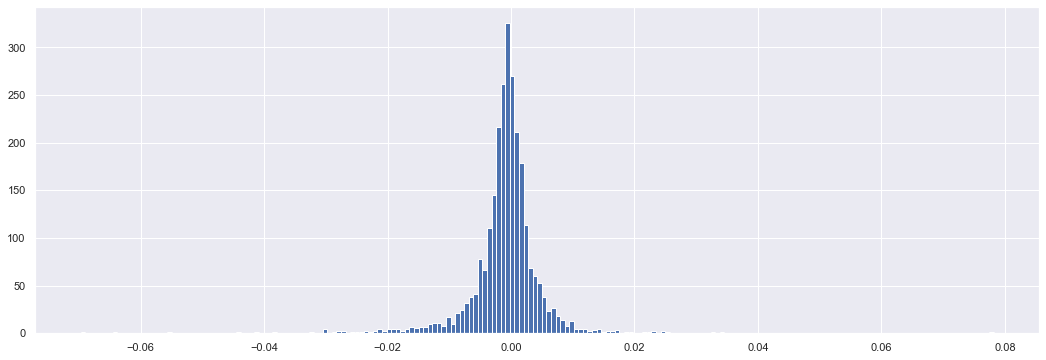

In [74]:
df_MA5_['gap_pct'].hist(bins = 200, figsize = (18,6))

In [75]:
df_MA5_.sort_values('gap_pct', ascending=False).head()

,open,close,MA5,pre_close,gap_pct,pre_MA5
date,,,,,,
2015-07-06,3975.214,3775.912,3941.3032,3686.915,0.078195,3996.7268
2015-10-08,3156.075,3143.357,3085.4756,3052.781,0.033836,3085.3416
2010-01-11,3301.611,3212.750,3227.5834,3195.997,0.033046,3233.7854
2011-12-01,2392.485,2386.860,2379.1850,2333.414,0.025315,2381.3238
2011-10-11,2401.738,2348.516,2361.9856,2344.787,0.024288,2375.2932


In [76]:
df_MA5_['pre_close_minus_pre_MA5'] = df_MA5_['pre_close'] - df_MA5_['pre_MA5']
df_MA5_['pre_cross'] = df_MA5_['pre_close_minus_pre_MA5'].apply(lambda x: 'gold' if x>0 else "dead")

In [78]:
df_MA5_

,open,close,MA5,pre_close,gap_pct,pre_MA5,pre_close_minus_pre_MA5,pre_cross
date,,,,,,,,
2009-01-05,1849.0200,1880.7160,1847.28580,NaN,NaN,NaN,NaN,dead
2009-01-06,1878.8270,1937.1450,1864.41120,1880.7160,-0.001004,1847.28580,33.43020,gold
2009-01-07,1938.9740,1924.0120,1879.11760,1937.1450,0.000944,1864.41120,72.73380,gold
2009-01-08,1890.2420,1878.1810,1888.17180,1924.0120,-0.017552,1879.11760,44.89440,gold
2009-01-09,1875.1640,1904.8610,1904.98300,1878.1810,-0.001606,1888.17180,-9.99080,dead
2009-01-12,1897.7030,1900.3470,1908.90920,1904.8610,-0.003758,1904.98300,-0.12200,dead
2009-01-13,1880.8680,1863.3670,1894.15360,1900.3470,-0.010250,1908.90920,-8.56220,dead
2009-01-14,1862.3100,1928.8690,1895.12500,1863.3670,-0.000567,1894.15360,-30.78660,dead
2009-01-15,1912.7720,1920.2060,1903.53000,1928.8690,-0.008345,1895.12500,33.74400,gold


In [79]:
df_MA5_['return'] = (df_MA5_['close'] - df_MA5_['open'])/df_MA5_['open']

In [82]:
# 昨日close在5日均线之上
y_gold = df_MA5_[df_MA5_['pre_close_minus_pre_MA5']>0]['return']
x_gap_pct_gold = df_MA5_[df_MA5_['pre_close_minus_pre_MA5']>0]['gap_pct']

# 昨日close在5日均线之下
y_dead = df_MA5_[df_MA5_['pre_close_minus_pre_MA5']<0]['return']
x_gap_pct_dead = df_MA5_[df_MA5_['pre_close_minus_pre_MA5']<0]['gap_pct']

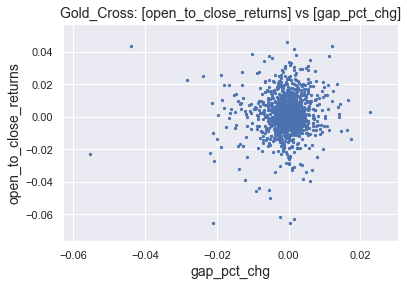

In [101]:
plt.scatter(x_gap_pct_gold,y_gold, s=5)
plt.title("Gold_Cross: [open_to_close_returns] vs [gap_pct_chg]",fontsize=14)
plt.xlabel("gap_pct_chg",fontsize=14)
plt.ylabel("open_to_close_returns",fontsize=14);

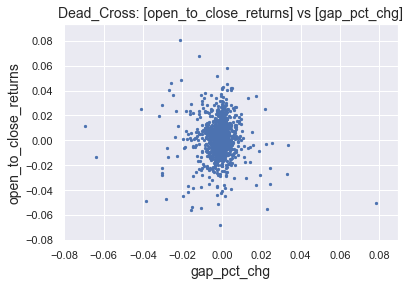

In [102]:
plt.scatter(x_gap_pct_dead,y_dead, s = 5)
plt.title("Dead_Cross: [open_to_close_returns] vs [gap_pct_chg]",fontsize=14)
plt.xlabel("gap_pct_chg",fontsize=14)
plt.ylabel("open_to_close_returns",fontsize=14);

In [106]:
# 金叉时做多：
df_MA5_[(df_MA5_['pre_close_minus_pre_MA5']>0)&(df_MA5_['return']>0)][['return','gap_pct']].sort_values("return", ascending = False).

,return,gap_pct
date,,
2015-07-10,4.594658e-02,-0.000505
2015-09-02,4.375928e-02,-0.043878
2019-02-25,4.329702e-02,0.012183
2014-12-04,4.166994e-02,0.001419
2014-12-08,3.866924e-02,-0.010155
2009-02-06,3.765845e-02,0.001935
2015-08-10,3.760717e-02,0.011171
2010-10-15,3.751111e-02,-0.005521
2014-12-02,3.588136e-02,-0.004602


In [108]:
# 死叉时做多：
df_MA5_[(df_MA5_['pre_close_minus_pre_MA5']<0)&(df_MA5_['return']>0)][['return','gap_pct']].sort_values("return", ascending = False)

,return,gap_pct
date,,
2015-07-09,0.080664,-0.021310
2015-06-30,0.067503,-0.011418
2009-03-04,0.058504,0.002503
2015-09-16,0.051443,-0.002375
2009-11-02,0.048685,-0.020706
2016-01-14,0.046485,-0.025613
2009-09-03,0.045079,0.002700
2012-12-14,0.042632,0.000588
2016-03-02,0.042401,0.000218


In [113]:
# 金叉时做空：
df_MA5_['return_short'] = df_MA5_['return']*(-1)
df_MA5_[(df_MA5_['pre_close_minus_pre_MA5']>0)&(df_MA5_['return_short']>0)][['return_short','gap_pct']].sort_values("return_short", ascending = False)

,return_short,gap_pct
date,,
2015-05-28,0.065431,0.000410
2015-07-27,0.065238,-0.020963
2015-08-18,0.062756,0.001369
2016-02-25,0.061936,-0.002273
2015-11-27,0.049838,-0.005228
2014-12-09,0.045521,-0.009194
2009-07-29,0.044900,-0.005346
2010-11-12,0.043719,-0.008203
2009-03-09,0.039442,0.005809


In [116]:
df_MA5_[(df_MA5_['pre_close_minus_pre_MA5']>0)&(df_MA5_['return_short']>0)]

,open,close,MA5,pre_close,gap_pct,pre_MA5,pre_close_minus_pre_MA5,pre_cross,return,return_short
date,,,,,,,,,,
2009-01-07,1938.9740,1924.0120,1879.11760,1937.1450,0.000944,1864.41120,72.73380,gold,-0.007716,0.007716
2009-01-08,1890.2420,1878.1810,1888.17180,1924.0120,-0.017552,1879.11760,44.89440,gold,-0.006381,0.006381
2009-01-23,2001.1720,1990.6570,1992.28060,2004.9510,-0.001885,1985.03680,19.91420,gold,-0.005254,0.005254
2009-02-05,2106.8350,2098.0180,2053.78300,2107.7490,-0.000434,2035.16960,72.57940,gold,-0.004185,0.004185
2009-02-12,2265.7890,2248.0910,2236.00500,2260.8200,0.002198,2205.99040,54.82960,gold,-0.007811,0.007811
2009-02-17,2387.3540,2319.4410,2307.70620,2389.3870,-0.000851,2296.85020,92.53680,gold,-0.028447,0.028447
2009-02-18,2271.2600,2209.8620,2297.51460,2319.4410,-0.020773,2307.70620,11.73480,gold,-0.027033,0.027033
2009-02-24,2273.7550,2200.6540,2240.97920,2305.7770,-0.013888,2264.73660,41.04040,gold,-0.032150,0.032150
2009-03-09,2205.7460,2118.7480,2160.47380,2193.0070,0.005809,2155.41360,37.59340,gold,-0.039442,0.039442


In [119]:
df_MA5_.to_csv("df_MA5.csv")

In [114]:
# 死叉时做空：
df_MA5_[(df_MA5_['pre_close_minus_pre_MA5']<0)&(df_MA5_['return_short']>0)][['return_short','gap_pct']].sort_values("return_short", ascending = False)

,return_short,gap_pct
date,,
2016-01-04,0.067956,-0.000733
2016-01-07,0.055793,-0.015522
2015-06-29,0.055187,0.023110
2016-01-26,0.054315,-0.010481
2009-08-31,0.053195,-0.015052
2013-06-24,0.051056,-0.002042
2015-07-06,0.050136,0.078195
2015-08-24,0.048488,-0.038277
2015-06-26,0.047060,-0.028236


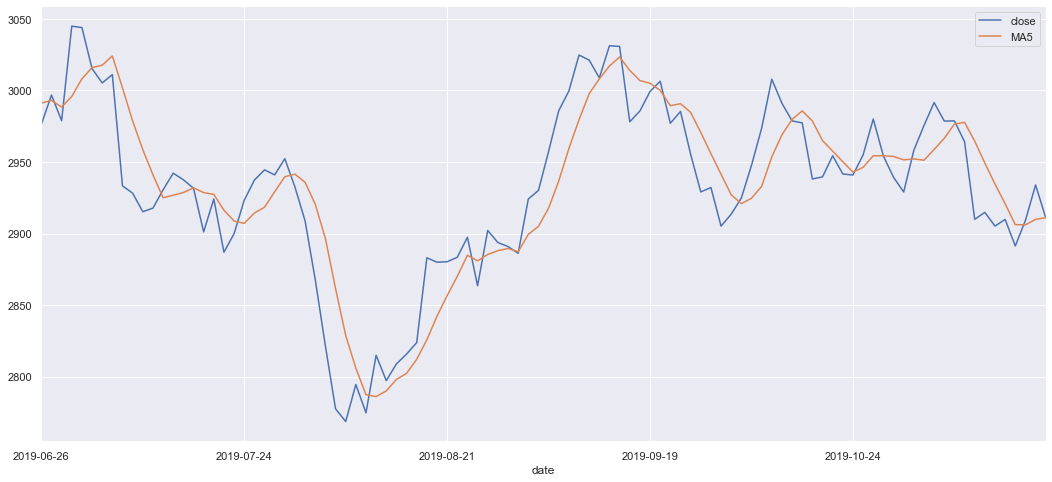

In [124]:
df_MA5_[['close', 'MA5']].tail(100).plot(figsize = (18, 8))

In [69]:
df_MA5_['gap_pct'].describe()

count    2401.000000
mean       -0.001087
std         0.005928
min        -0.069685
25%        -0.002550
50%        -0.000639
75%         0.001038
max         0.078195
Name: gap_pct, dtype: float64

## 其他股票

In [2]:
today = str(datetime.now().date())

def get_data(code,start='20100101',end=today):
    df = ts.pro_bar(ts_code=code, adj='qfq', start_date=start, end_date=end)
    return df

#获取当前交易日最新的股票代码和简称
def get_code():
    codes = pro.stock_basic(list_status='L').ts_code.values
    return codes

#设置token
token='2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67'
pro = ts.pro_api(token)
codes = get_code()

In [5]:
len(codes)

3732

In [4]:
import eventlet
eventlet.monkey_patch()

ch_db_path = "C:/Users/Administrator/Documents/GitHub/mac_win_since_20191006/research_mac_win/CH_database/"

ticker_list = codes[:4]
today = str(datetime.now().date())
start = "2010-01-01"
end = today
for ticker in ticker_list:
    if not os.path.exists(ch_db_path+ticker+".csv"):
        print("{} is new, start downloading now...".format(ticker))
        try:
            data = get_data(ticker)
            data.sort_values("trade_date", inplace = True)
            data.to_csv(ch_db_path+ticker+".csv", index = False)
            print("{} data file created: {}".format(ticker, end))
        except Exception as e:
            print(e)
            
    else:
        print("Already have data csv for {}".format(ticker))
        hist_data = pd.read_csv(ch_db_path+ticker+".csv", encoding = "ANSI")
        try:
            hist_data_last_date = hist_data['trade_date'].values[-1]
            if today > hist_data_last_date:
                print("Needs to update, start updating new data for {} now...".format(ticker))
                update_start = hist_data_last_date
                update_end = today
                with eventlet.Timeout(60,False):
                    try:
                        new_data = get_code(ticker, start=update_start, end=update_end)
                        new_data.to_csv(ch_db_path+ticker+".csv", mode='a', header=False, index = False)
                        updated_duplicated_df = pd.read_csv(ch_db_path+ticker+".csv", encoding = "ANSI")
                        updated_df = updated_duplicated_df.drop_duplicates("trade_date")
                        updated_df.to_csv(ch_db_path+ticker+".csv", index = False)
                        print("New data updated till today for {}!".format(ticker))
                    except Exception as e:
                        print(e)
    #             print("Timed Out: Update Failed!")
            else:
                print("There's no new data to update for {}.".format(ticker))
        except Exception as e:
            print(e)

#     print("Data Download/Update for {} is Finished.".format(ticker))
    print("===============================================")
    
print("【Updated Finished for today!】")

ImportError: No module named 'eventlet'

In [17]:
# us_db_path = "C:/Users/Administrator/Documents/GitHub/mac_win_since_20191006/research_mac_win/US_database/"

# ticker_list = sp500_list

# today = str(datetime.now().date())
# start = "1990-01-01"
# end = today
# for ticker in ticker_list:
#     # Initial downloading:
#     if not os.path.exists(us_db_path+ticker+".csv"):
#         print("{} is new, start downloading now...".format(ticker))
#         data = yf.download(ticker, start=start, end=end)
#         data.reset_index(inplace = True)
#         data['Ticker'] = ticker
#         data.to_csv(us_db_path+ticker+".csv", index = False)
#         print("{} data file created: {}".format(ticker, end))
#     # Check for updates:
#     else:
#         print("Already have data csv for {}".format(ticker))
#         hist_data = pd.read_csv(us_db_path+ticker+".csv", encoding = "ANSI")
#         hist_data_last_date = hist_data['Date'].values[-1]
#         if today > hist_data_last_date:
#             print("Needs to update, start updating new data for {} now...".format(ticker))
#             update_start = hist_data_last_date
#             update_end = today
#             new_data = yf.download(ticker, start=update_start, end=update_end)
#             new_data.reset_index(inplace = True)
#             new_data['Ticker'] = ticker
#             new_data.to_csv(us_db_path+ticker+".csv", mode='a', header=False, index = False)
#             updated_duplicated_df = pd.read_csv(us_db_path+ticker+".csv", encoding = "ANSI")
#             updated_df = updated_duplicated_df.drop_duplicates()
#             updated_df.to_csv(us_db_path+ticker+".csv", index = False)
#             print("New data updated till today for {}!".format(ticker))
#         else:
#             print("There's no new data to update for {}.".format(ticker))
#     print("Data Download/Update for {} is Finished.".format(ticker))
#     print("===============================================")

In [ ]:
# Updating Data
# ticker_list = ["AAPL","GOOGL"]
# today = str(datetime.now().date())
# for ticker in ticker_list:
#     hist_data = pd.read_csv(ticker+".csv", encoding = "ANSI")
#     hist_data_last_date = hist_data['Date'].values[-1]
#     if today > hist_data_last_date:
#         print("Updating new data...")
#         update_start = hist_data_last_date
#         update_end = today
#         new_data = yf.download(ticker, start=update_start, end=update_end)
#         new_data.reset_index(inplace = True)
#         new_data['Ticker'] = ticker
#         new_data.to_csv(ticker+".csv", mode='a', header=False, index = False)
#         updated_duplicated_df = pd.read_csv(ticker+".csv", encoding = "ANSI")
#         updated_df = updated_duplicated_df.drop_duplicates()
#         updated_df.to_csv(ticker+".csv", index = False)
#         print("New data updated till today for {}!".format(ticker))
#     else:
#         print("There's no new data to update for {}.".format(ticker))

In [4]:
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

stock = pd.read_csv(ch_db_path+"000001.sz.csv")

In [46]:
stock.head(2)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20100104,8.0647,8.0844,7.7884,7.7983,8.0154,-0.2171,-2.7085,241922.76,5.802495e+05
1,000001.SZ,20100105,7.8114,7.8608,7.4825,7.6634,7.7983,-0.1349,-1.7299,556499.82,1.293477e+06


In [52]:
def MACD(df, n_fast, n_slow, n_macd): # n_fast = 12, n_slow = 26
    """
    
    http://stockcharts.com/docs/doku.php?id=scans:indicators

    """
    """
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df['close'].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df['close'].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['MACD_signal'] = df['MACD'].apply(lambda x: "多头信号" if x>0 else ("空头信号" if x<0 else "空仓信号"))
#     return MACD, MACDsign, MACDdiff
    return df

In [48]:
import glob
import os

In [49]:
csv_path = ch_db_path+"*.csv"

In [50]:
files = glob.glob(csv_path)

In [22]:
code_list = []
for file in files:
    ticker = file.split("CH_database/")[1].split(".csv")[0]
    code_list.append(ticker)

In [33]:
code_list

['000001.SZ',
 '000002.SZ',
 '000004.SZ',
 '000005.SZ',
 '000006.SZ',
 '000007.SZ',
 '000008.SZ',
 '000009.SZ',
 '000010.SZ',
 '000011.SZ',
 '000012.SZ',
 '000014.SZ',
 '000016.SZ',
 '000017.SZ',
 '000018.SZ',
 '000019.SZ',
 '000020.SZ',
 '000021.SZ',
 '000023.SZ',
 '000025.SZ',
 '000026.SZ',
 '000027.SZ',
 '000028.SZ',
 '000029.SZ',
 '000030.SZ',
 '000031.SZ',
 '000032.SZ',
 '000034.SZ',
 '000035.SZ',
 '000036.SZ',
 '000037.SZ',
 '000038.SZ',
 '000039.SZ',
 '000040.SZ',
 '000042.SZ',
 '000043.SZ',
 '000045.SZ',
 '000046.SZ',
 '000048.SZ',
 '000049.SZ',
 '000050.SZ',
 '000055.SZ',
 '000056.SZ',
 '000058.SZ',
 '000059.SZ',
 '000060.SZ',
 '000061.SZ',
 '000062.SZ',
 '000063.SZ',
 '000065.SZ',
 '000066.SZ',
 '000068.SZ',
 '000069.SZ',
 '000070.SZ',
 '000078.SZ',
 '000088.SZ',
 '000089.SZ',
 '000090.SZ',
 '000096.SZ',
 '000099.SZ',
 '000100.SZ',
 '000150.SZ',
 '000151.SZ',
 '000153.SZ',
 '000155.SZ',
 '000156.SZ',
 '000157.SZ',
 '000158.SZ',
 '000159.SZ',
 '000166.SZ',
 '000301.SZ',
 '0003

In [27]:
# analysis_tickers = ['AAPL',"GOOG","TSLA"]
# analysis_tickers = sp500()

In [28]:
ticker_df_list = []
for ticker in code_list:
    print("Reading: ", ticker)
    ticker_df = pd.read_csv(ch_db_path+ticker+".csv")
    ticker_df_list.append(ticker_df)

Reading:  000001.SZ
Reading:  000002.SZ
Reading:  000004.SZ
Reading:  000005.SZ
Reading:  000006.SZ
Reading:  000007.SZ
Reading:  000008.SZ
Reading:  000009.SZ
Reading:  000010.SZ
Reading:  000011.SZ
Reading:  000012.SZ
Reading:  000014.SZ
Reading:  000016.SZ
Reading:  000017.SZ
Reading:  000018.SZ
Reading:  000019.SZ
Reading:  000020.SZ
Reading:  000021.SZ
Reading:  000023.SZ
Reading:  000025.SZ
Reading:  000026.SZ
Reading:  000027.SZ
Reading:  000028.SZ
Reading:  000029.SZ
Reading:  000030.SZ
Reading:  000031.SZ
Reading:  000032.SZ
Reading:  000034.SZ
Reading:  000035.SZ
Reading:  000036.SZ
Reading:  000037.SZ
Reading:  000038.SZ
Reading:  000039.SZ
Reading:  000040.SZ
Reading:  000042.SZ
Reading:  000043.SZ
Reading:  000045.SZ
Reading:  000046.SZ
Reading:  000048.SZ
Reading:  000049.SZ
Reading:  000050.SZ
Reading:  000055.SZ
Reading:  000056.SZ
Reading:  000058.SZ
Reading:  000059.SZ
Reading:  000060.SZ
Reading:  000061.SZ
Reading:  000062.SZ
Reading:  000063.SZ
Reading:  000065.SZ


Reading:  000961.SZ
Reading:  000962.SZ
Reading:  000963.SZ
Reading:  000965.SZ
Reading:  000966.SZ
Reading:  000967.SZ
Reading:  000968.SZ
Reading:  000969.SZ
Reading:  000970.SZ
Reading:  000971.SZ
Reading:  000972.SZ
Reading:  000973.SZ
Reading:  000975.SZ
Reading:  000976.SZ
Reading:  000977.SZ
Reading:  000978.SZ
Reading:  000980.SZ
Reading:  000981.SZ
Reading:  000982.SZ
Reading:  000983.SZ
Reading:  000985.SZ
Reading:  000987.SZ
Reading:  000988.SZ
Reading:  000989.SZ
Reading:  000990.SZ
Reading:  000993.SZ
Reading:  000996.SZ
Reading:  000997.SZ
Reading:  000998.SZ
Reading:  000999.SZ
Reading:  001696.SZ
Reading:  001872.SZ
Reading:  001896.SZ
Reading:  001965.SZ
Reading:  001979.SZ
Reading:  002001.SZ
Reading:  002002.SZ
Reading:  002003.SZ
Reading:  002004.SZ
Reading:  002005.SZ
Reading:  002006.SZ
Reading:  002007.SZ
Reading:  002008.SZ
Reading:  002009.SZ
Reading:  002010.SZ
Reading:  002011.SZ
Reading:  002012.SZ
Reading:  002013.SZ
Reading:  002014.SZ
Reading:  002015.SZ


Reading:  002384.SZ
Reading:  002385.SZ
Reading:  002386.SZ
Reading:  002387.SZ
Reading:  002388.SZ
Reading:  002389.SZ
Reading:  002390.SZ
Reading:  002391.SZ
Reading:  002392.SZ
Reading:  002393.SZ
Reading:  002394.SZ
Reading:  002395.SZ
Reading:  002396.SZ
Reading:  002397.SZ
Reading:  002398.SZ
Reading:  002399.SZ
Reading:  002400.SZ
Reading:  002401.SZ
Reading:  002402.SZ
Reading:  002403.SZ
Reading:  002404.SZ
Reading:  002405.SZ
Reading:  002406.SZ
Reading:  002407.SZ
Reading:  002408.SZ
Reading:  002409.SZ
Reading:  002410.SZ
Reading:  002411.SZ
Reading:  002412.SZ
Reading:  002413.SZ
Reading:  002414.SZ
Reading:  002415.SZ
Reading:  002416.SZ
Reading:  002417.SZ
Reading:  002418.SZ
Reading:  002419.SZ
Reading:  002420.SZ
Reading:  002421.SZ
Reading:  002422.SZ
Reading:  002423.SZ
Reading:  002424.SZ
Reading:  002425.SZ
Reading:  002426.SZ
Reading:  002427.SZ
Reading:  002428.SZ
Reading:  002429.SZ
Reading:  002430.SZ
Reading:  002431.SZ
Reading:  002432.SZ
Reading:  002433.SZ


Reading:  002841.SZ
Reading:  002842.SZ
Reading:  002843.SZ
Reading:  002845.SZ
Reading:  002846.SZ
Reading:  002847.SZ
Reading:  002848.SZ
Reading:  002849.SZ
Reading:  002850.SZ
Reading:  002851.SZ
Reading:  002852.SZ
Reading:  002853.SZ
Reading:  002855.SZ
Reading:  002856.SZ
Reading:  002857.SZ
Reading:  002858.SZ
Reading:  002859.SZ
Reading:  002860.SZ
Reading:  002861.SZ
Reading:  002862.SZ
Reading:  002863.SZ
Reading:  002864.SZ
Reading:  002865.SZ
Reading:  002866.SZ
Reading:  002867.SZ
Reading:  002868.SZ
Reading:  002869.SZ
Reading:  002870.SZ
Reading:  002871.SZ
Reading:  002872.SZ
Reading:  002873.SZ
Reading:  002875.SZ
Reading:  002876.SZ
Reading:  002877.SZ
Reading:  002878.SZ
Reading:  002879.SZ
Reading:  002880.SZ
Reading:  002881.SZ
Reading:  002882.SZ
Reading:  002883.SZ
Reading:  002884.SZ
Reading:  002885.SZ
Reading:  002886.SZ
Reading:  002887.SZ
Reading:  002888.SZ
Reading:  002889.SZ
Reading:  002890.SZ
Reading:  002891.SZ
Reading:  002892.SZ
Reading:  002893.SZ


Reading:  300331.SZ
Reading:  300332.SZ
Reading:  300333.SZ
Reading:  300334.SZ
Reading:  300335.SZ
Reading:  300336.SZ
Reading:  300337.SZ
Reading:  300338.SZ
Reading:  300339.SZ
Reading:  300340.SZ
Reading:  300341.SZ
Reading:  300342.SZ
Reading:  300343.SZ
Reading:  300344.SZ
Reading:  300345.SZ
Reading:  300346.SZ
Reading:  300347.SZ
Reading:  300348.SZ
Reading:  300349.SZ
Reading:  300350.SZ
Reading:  300351.SZ
Reading:  300352.SZ
Reading:  300353.SZ
Reading:  300354.SZ
Reading:  300355.SZ
Reading:  300356.SZ
Reading:  300357.SZ
Reading:  300358.SZ
Reading:  300359.SZ
Reading:  300360.SZ
Reading:  300362.SZ
Reading:  300363.SZ
Reading:  300364.SZ
Reading:  300365.SZ
Reading:  300366.SZ
Reading:  300367.SZ
Reading:  300368.SZ
Reading:  300369.SZ
Reading:  300370.SZ
Reading:  300371.SZ
Reading:  300373.SZ
Reading:  300374.SZ
Reading:  300375.SZ
Reading:  300376.SZ
Reading:  300377.SZ
Reading:  300378.SZ
Reading:  300379.SZ
Reading:  300380.SZ
Reading:  300381.SZ
Reading:  300382.SZ


Reading:  300776.SZ
Reading:  300777.SZ
Reading:  300778.SZ
Reading:  300779.SZ
Reading:  300780.SZ
Reading:  300781.SZ
Reading:  300782.SZ
Reading:  300783.SZ
Reading:  300785.SZ
Reading:  300786.SZ
Reading:  300787.SZ
Reading:  300788.SZ
Reading:  300789.SZ
Reading:  300790.SZ
Reading:  300791.SZ
Reading:  300792.SZ
Reading:  300793.SZ
Reading:  300795.SZ
Reading:  300796.SZ
Reading:  300797.SZ
Reading:  300798.SZ
Reading:  300799.SZ
Reading:  300800.SZ
Reading:  300801.SZ
Reading:  300802.SZ
Reading:  300803.SZ
Reading:  300805.SZ
Reading:  300806.SZ
Reading:  300808.SZ
Reading:  600000.SH
Reading:  600004.SH
Reading:  600006.SH
Reading:  600007.SH
Reading:  600008.SH
Reading:  600009.SH
Reading:  600010.SH
Reading:  600011.SH
Reading:  600012.SH
Reading:  600015.SH
Reading:  600016.SH
Reading:  600017.SH
Reading:  600018.SH
Reading:  600019.SH
Reading:  600020.SH
Reading:  600021.SH
Reading:  600022.SH
Reading:  600023.SH
Reading:  600025.SH
Reading:  600026.SH
Reading:  600027.SH


Reading:  600486.SH
Reading:  600487.SH
Reading:  600488.SH
Reading:  600489.SH
Reading:  600490.SH
Reading:  600491.SH
Reading:  600493.SH
Reading:  600495.SH
Reading:  600496.SH
Reading:  600497.SH
Reading:  600498.SH
Reading:  600499.SH
Reading:  600500.SH
Reading:  600501.SH
Reading:  600502.SH
Reading:  600503.SH
Reading:  600505.SH
Reading:  600506.SH
Reading:  600507.SH
Reading:  600508.SH
Reading:  600509.SH
Reading:  600510.SH
Reading:  600511.SH
Reading:  600512.SH
Reading:  600513.SH
Reading:  600515.SH
Reading:  600516.SH
Reading:  600517.SH
Reading:  600518.SH
Reading:  600519.SH
Reading:  600520.SH
Reading:  600521.SH
Reading:  600522.SH
Reading:  600523.SH
Reading:  600525.SH
Reading:  600526.SH
Reading:  600527.SH
Reading:  600528.SH
Reading:  600529.SH
Reading:  600530.SH
Reading:  600531.SH
Reading:  600532.SH
Reading:  600533.SH
Reading:  600535.SH
Reading:  600536.SH
Reading:  600537.SH
Reading:  600538.SH
Reading:  600539.SH
Reading:  600540.SH
Reading:  600543.SH


Reading:  600992.SH
Reading:  600993.SH
Reading:  600995.SH
Reading:  600996.SH
Reading:  600997.SH
Reading:  600998.SH
Reading:  600999.SH
Reading:  601000.SH
Reading:  601001.SH
Reading:  601002.SH
Reading:  601003.SH
Reading:  601005.SH
Reading:  601006.SH
Reading:  601007.SH
Reading:  601008.SH
Reading:  601009.SH
Reading:  601010.SH
Reading:  601011.SH
Reading:  601012.SH
Reading:  601015.SH
Reading:  601016.SH
Reading:  601018.SH
Reading:  601019.SH
Reading:  601020.SH
Reading:  601021.SH
Reading:  601028.SH
Reading:  601038.SH
Reading:  601058.SH
Reading:  601066.SH
Reading:  601068.SH
Reading:  601069.SH
Reading:  601077.SH
Reading:  601086.SH
Reading:  601088.SH
Reading:  601098.SH
Reading:  601099.SH
Reading:  601100.SH
Reading:  601101.SH
Reading:  601106.SH
Reading:  601107.SH
Reading:  601108.SH
Reading:  601111.SH
Reading:  601113.SH
Reading:  601116.SH
Reading:  601117.SH
Reading:  601118.SH
Reading:  601126.SH
Reading:  601127.SH
Reading:  601128.SH
Reading:  601137.SH


Reading:  603580.SH
Reading:  603583.SH
Reading:  603585.SH
Reading:  603586.SH
Reading:  603587.SH
Reading:  603588.SH
Reading:  603589.SH
Reading:  603590.SH
Reading:  603595.SH
Reading:  603596.SH
Reading:  603598.SH
Reading:  603599.SH
Reading:  603600.SH
Reading:  603601.SH
Reading:  603602.SH
Reading:  603603.SH
Reading:  603605.SH
Reading:  603606.SH
Reading:  603607.SH
Reading:  603608.SH
Reading:  603609.SH
Reading:  603610.SH
Reading:  603611.SH
Reading:  603612.SH
Reading:  603613.SH
Reading:  603615.SH
Reading:  603616.SH
Reading:  603617.SH
Reading:  603618.SH
Reading:  603619.SH
Reading:  603626.SH
Reading:  603628.SH
Reading:  603629.SH
Reading:  603630.SH
Reading:  603633.SH
Reading:  603636.SH
Reading:  603637.SH
Reading:  603638.SH
Reading:  603639.SH
Reading:  603648.SH
Reading:  603650.SH
Reading:  603655.SH
Reading:  603656.SH
Reading:  603657.SH
Reading:  603658.SH
Reading:  603659.SH
Reading:  603660.SH
Reading:  603661.SH
Reading:  603662.SH
Reading:  603663.SH


In [29]:
tickers = pd.concat(ticker_df_list)

In [31]:
tickers[tickers['ts_code']=="000001.SZ"]

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20100104,8.0647,8.0844,7.7884,7.7983,8.0154,-0.2171,-2.7085,241922.76,5.802495e+05
1,000001.SZ,20100105,7.8114,7.8608,7.4825,7.6634,7.7983,-0.1349,-1.7299,556499.82,1.293477e+06
2,000001.SZ,20100106,7.6470,7.6470,7.4727,7.5319,7.6634,-0.1315,-1.7159,412143.13,9.444537e+05
3,000001.SZ,20100107,7.5319,7.5812,7.3674,7.4497,7.5319,-0.0822,-1.0914,355336.85,8.041663e+05
4,000001.SZ,20100108,7.4003,7.4825,7.3510,7.4332,7.4497,-0.0165,-0.2215,288543.06,6.506674e+05
5,000001.SZ,20100111,7.7292,7.7884,7.3280,7.4332,7.4332,0.0000,0.0000,442846.02,1.009986e+06
6,000001.SZ,20100112,7.4233,7.4497,7.1701,7.3839,7.4332,-0.0493,-0.6632,591795.91,1.310069e+06
7,000001.SZ,20100113,7.1931,7.2030,6.8412,6.8938,7.3839,-0.4901,-6.6374,935039.47,1.990493e+06
8,000001.SZ,20100114,6.9070,6.9596,6.7754,6.8971,6.8938,0.0033,0.0479,521194.74,1.089329e+06
9,000001.SZ,20100115,6.9135,7.1207,6.7918,7.0484,6.8971,0.1513,2.1937,539508.46,1.146375e+06


In [66]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

In [70]:
tickers_test = tickers[(tickers['ts_code']=="000001.SZ")|(tickers['ts_code']=="000002.SZ")]

In [71]:
tickers_test

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20100104,8.0647,8.0844,7.7884,7.7983,8.0154,-0.2171,-2.7085,241922.76,5.802495e+05
1,000001.SZ,20100105,7.8114,7.8608,7.4825,7.6634,7.7983,-0.1349,-1.7299,556499.82,1.293477e+06
2,000001.SZ,20100106,7.6470,7.6470,7.4727,7.5319,7.6634,-0.1315,-1.7159,412143.13,9.444537e+05
3,000001.SZ,20100107,7.5319,7.5812,7.3674,7.4497,7.5319,-0.0822,-1.0914,355336.85,8.041663e+05
4,000001.SZ,20100108,7.4003,7.4825,7.3510,7.4332,7.4497,-0.0165,-0.2215,288543.06,6.506674e+05
5,000001.SZ,20100111,7.7292,7.7884,7.3280,7.4332,7.4332,0.0000,0.0000,442846.02,1.009986e+06
6,000001.SZ,20100112,7.4233,7.4497,7.1701,7.3839,7.4332,-0.0493,-0.6632,591795.91,1.310069e+06
7,000001.SZ,20100113,7.1931,7.2030,6.8412,6.8938,7.3839,-0.4901,-6.6374,935039.47,1.990493e+06
8,000001.SZ,20100114,6.9070,6.9596,6.7754,6.8971,6.8938,0.0033,0.0479,521194.74,1.089329e+06
9,000001.SZ,20100115,6.9135,7.1207,6.7918,7.0484,6.8971,0.1513,2.1937,539508.46,1.146375e+06


In [77]:
tickers_test['10_vol_ewm'] = tickers_test.groupby(['ts_code'])['vol'].apply(lambda x: vol_ewm(x, 10))

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


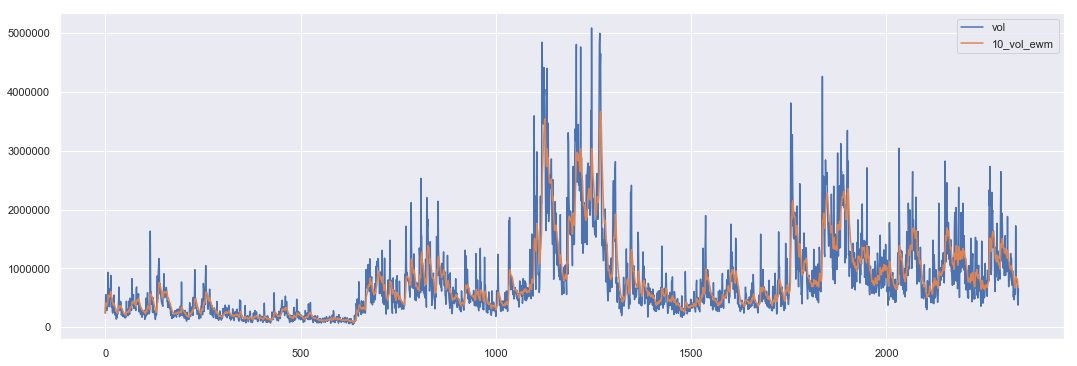

In [82]:
tickers_test[tickers_test['ts_code']=="000001.SZ"][['vol','10_vol_ewm']].plot(figsize = (18, 6))

In [53]:
signal_record = []
for ticker in code_list[:10]:
    print("Calculating Signal for: ", ticker)
    try:
        single_ticker_df = tickers[tickers['ts_code']==ticker]
        signal_df = MACD(single_ticker_df, 12, 26, 9)
        last_signal = signal_df[['ts_code','MACD_signal']].values[-1]
        signal_record.append(last_signal)
    except:
        pass

Calculating Signal for:  000001.SZ


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Calculating Signal for:  000002.SZ
Calculating Signal for:  000004.SZ
Calculating Signal for:  000005.SZ
Calculating Signal for:  000006.SZ
Calculating Signal for:  000007.SZ
Calculating Signal for:  000008.SZ
Calculating Signal for:  000009.SZ
Calculating Signal for:  000010.SZ
Calculating Signal for:  000011.SZ


In [59]:
signal_record

[array(['000001.SZ', '空头信号'], dtype=object),
 array(['000002.SZ', '多头信号'], dtype=object),
 array(['000004.SZ', '多头信号'], dtype=object),
 array(['000005.SZ', '多头信号'], dtype=object),
 array(['000006.SZ', '多头信号'], dtype=object),
 array(['000007.SZ', '空头信号'], dtype=object),
 array(['000008.SZ', '多头信号'], dtype=object),
 array(['000009.SZ', '空头信号'], dtype=object),
 array(['000010.SZ', '空头信号'], dtype=object),
 array(['000011.SZ', '多头信号'], dtype=object)]

In [61]:
signal_record

[array(['000001.SZ', '空头信号'], dtype=object),
 array(['000002.SZ', '多头信号'], dtype=object),
 array(['000004.SZ', '多头信号'], dtype=object),
 array(['000005.SZ', '多头信号'], dtype=object),
 array(['000006.SZ', '多头信号'], dtype=object),
 array(['000007.SZ', '空头信号'], dtype=object),
 array(['000008.SZ', '多头信号'], dtype=object),
 array(['000009.SZ', '空头信号'], dtype=object),
 array(['000010.SZ', '空头信号'], dtype=object),
 array(['000011.SZ', '多头信号'], dtype=object)]